In [1]:
import numpy as np
import pandas as pd
import torch
import os
import multiprocessing as mp
import seaborn as sns
import glob
import pylab
import json
import sys
from tqdm.notebook import tqdm
import gc
import h5py
import torchvision
sys.path.insert(0, os.path.abspath('..'))
from src.wrappers import get_wrapper
from src.datasets import get_dataset

# Set constants
attributes = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young".split(" ")
datadir = '../data'
results_path = '../logs/bte'


# Beyond Trivial Explanations
1. Parse results from the BTE experiment
2. Plot non-trivial explanations against VGG similarity

In [2]:
def process_results(path):
    i, path = path
    if i % 50 == 0:
        print(i)

    with open(os.path.join(os.path.dirname(path), 'exp_dict.json'), 'r') as infile:
        exp_dict = json.load(infile)
    with open(os.path.join(datadir, os.path.join(exp_dict['generator_path']), 'exp_dict.json'), 'r') as infile:
        cls_dict = json.load(infile)
        cls_dict['labels_path'] = 'celeba_meta_explanations/list_eval_unbiased.csv'
    att_idx = attributes.index(exp_dict["attribute"])
    ret = {}
    keys = ['logits', 'labels', 'oracle_preds_attack', 'oracle_preds_reconstruction']
    with h5py.File(path, 'r') as infile:
        for k in keys: 
            ret[k] = infile[k][..., att_idx]
        for k in ['latent_similarity', 'idx']:
            ret[k] = infile[k][:]
    
    dataset = get_dataset(datadir, 'val', cls_dict)
    ret['labels'] = dataset.y[ret['idx'], att_idx, None]
    ret.update(exp_dict)
    gc.collect()
    return ret

NUM_CPU = 8
# Parse results in parallel
with mp.Pool(NUM_CPU) as pool:
    ret = pool.map(process_results, enumerate(glob.glob(os.path.join(results_path, '*/results.h5'))))

# Compute final scores and save into dataframe
df = pd.DataFrame(ret)
df['logits'] = df['logits'].apply(lambda x: x > 0)
df['oracle_preds_reconstruction'] = df['oracle_preds_reconstruction'].apply(lambda x: x > 0)
df['oracle_preds_attack'] = df['oracle_preds_attack'].apply(lambda x: x > 0)
df['non-trivial'] = [((attack != oracle) & (oracle_attack == oracle)).sum() / ((attack != oracle)).sum() for attack, oracle, oracle_attack, label in zip(df['logits'].values, df['oracle_preds_reconstruction'].values, df['oracle_preds_attack'].values, df['labels'].values)]
df['latent_similarity'] = df['latent_similarity'].apply(np.nanmean)
display(df[['method', 'lr', 'non-trivial', 'score', 'latent_similarity', 'lasso_weight', 'reconstruction_weight', 'diversity_weight']])
df_backup = df.copy()

0100



/mnt/home/miniconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/mnt/home/miniconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/mnt/home/miniconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/mnt/home/miniconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/mnt/home/miniconda3/lib/python3.8/site-packages/torchvision/transforms/

50
150
200
300
250
400
350
450
500
600
550


,method,lr,non-trivial,score,latent_similarity,lasso_weight,reconstruction_weight,diversity_weight
0,dive,0.005,0.669935,0.669935,0.951163,10.0000,0.0100,0.001
1,random,0.005,0.600000,0.600000,0.951340,10.0000,0.0100,0.001
2,xgem+,0.005,0.405941,0.405941,0.832804,0.0000,0.0100,0.000
3,fisher_spectral,0.005,0.611872,0.611872,0.953247,10.0000,0.0100,0.001
4,fisher_spectral,0.100,0.510753,0.510753,0.923447,1.0000,0.0001,0.001
...,...,...,...,...,...,...,...,...
635,fisher_spectral,0.100,0.441048,0.441048,0.927752,0.0001,0.0100,0.100
636,xgem+,0.010,0.226415,0.226415,0.834594,0.0000,0.0100,0.000
637,random,0.100,0.294408,0.294408,0.928911,0.0001,0.0100,0.100
638,dive,0.100,0.308748,0.308748,0.930737,0.0001,0.0100,0.100


## BTE PLOT

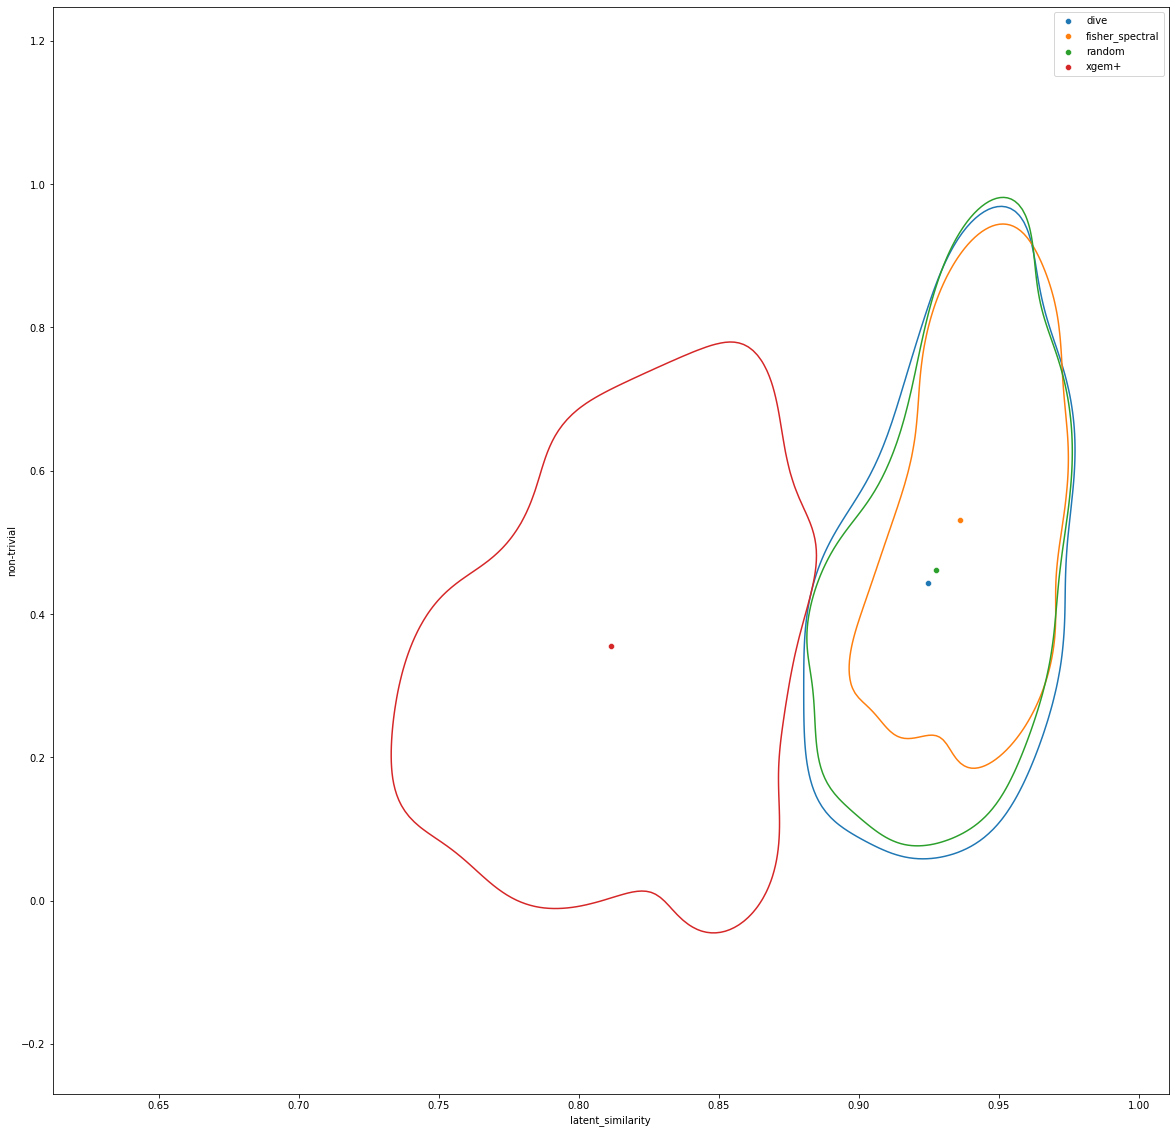

In [6]:
pylab.figure(figsize=(20,20))
for method in list(sorted(set(df['method']))):
    sns.kdeplot(df[df['method'] == method]['latent_similarity'], y=df[df['method'] == method]['non-trivial'], levels=[0.22])
    sns.scatterplot(x=[df[df['method'] == method]['latent_similarity'].values.mean()], y=[df[df['method'] == method]['non-trivial'].values.mean()], label=method)
pylab.title('BTE')
pylab.legend()